In [114]:
import numpy as np
import pandas as pd

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# GLM 
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Import Machine learning algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier # Import RandomForestClassifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.preprocessing import StandardScaler # Import Feature Importance StandardScaler

# Import metric for performance evaluation
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix

# undersampling for class imbalance
from imblearn.under_sampling import RandomUnderSampler

# Import feature and tree visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from matplotlib import style
import plotly.express as px 


In [147]:
# create dataframe with project's data set
df = pd.read_csv('HR.csv')
print(df.columns)

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')


## Data Preprocesssing

In [148]:
# deleting clearly unuseful variables (employee count, employee number, over 18, Standard Hours)
df = df.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis=1)

# drop rows that contain at least one empty cell
df.dropna(axis='rows', thresh=1)

# feature engineering
def binary_map(feature):
    return feature.map({'Yes':1, 'No':0})

# encoding Gender categorical data
df['Gender'] = df['Gender'].map({'Male':1, 'Female':0})

# encoding Attrition and Overtime
binary_list = ['Attrition', 'OverTime']
df[binary_list] = df[binary_list].apply(binary_map)

# one-hot encoding of features with more than two categories
df = pd.get_dummies(df, drop_first=True)

## Split Dataset into Test and Training

In [153]:
# Split dataset into training set and test set
# --->> use train set only for GLM and correlation already
X = df.drop('Attrition', axis=1)
y = df['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                   y, test_size=0.3, random_state=50)

# dealing with class imbalance
# needs to be adjusted!!
# split them by hand maybe
rus = RandomUnderSampler(random_state=0)
rus.fit(X_train, y_train)
X_train, y_train = rus.fit_resample(X_train, y_train)

## Data Preprocessing of Training Set

In [154]:
# feature scaling for logistic regression - MinMax Scaler (better for data sets that include outliers)
# use df_regr for logistic regression model as decision trees don't need feature scaling
sc = MinMaxScaler()
to_scale = [col for col in X_train.columns if X_train[col].nunique() > 2]
for col in to_scale:
    X_train[col] = sc.fit_transform(X_train[[col]])
    
# feature scaling via Standard Scaler(not to be used with datasets that include outliers)
# sc_ = StandardScaler()
# to_scale = [col for col in X_train.columns if X_train[col].nunique() > 2]
# for col in to_scale:
    # X_train[col] = sc.fit_transform(X_train[[col]])

## Feature Correlation Check

In [119]:
# visualize correlation between features
# which correlation method makes most sense for our data set?
corr = X_train.corr()
fig = px.imshow(corr, width=1000, height=1000)
fig.show()

# potentially drop highly correleated features
# explain why we will or will not drop the feature
cor_matrix = X_train.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
# if to_drop:
    # X_train = X_train.drop(columns=to_drop, axis=1)
print("Highly correlated feature(s) dropped: ", to_drop)

Highly correlated feature(s) dropped:  []


## GLM regression model 

In [149]:
# GLM based on Train set
# df_glm = X_train
# df_glm.insert(0, 'Attrition', y_train)

# GLM based on all data
df_glm = df

# change variable name seperators
df_glm.columns = (column.replace(" ", "_").replace("(", 
                  "_").replace("&", "_").replace("-", "_")
                  for column in df_glm.columns)

# transfer the change to the dataframe column names
glm_columns = [col for col in df_glm.columns if col != 'Attrition']

# prepare columns for the glm formula
glm_columns = ' + '.join(map(str, glm_columns))

# fit the GLM
glm_model = smf.glm(formula=f'Attrition ~ {glm_columns}',
                    data=df_glm, family=sm.families.Binomial())
res = glm_model.fit()
print(res.summary())

# take the exponent of the variable coefficents to determine which features are most important for training the model
np.exp(res.params)


                 Generalized Linear Model Regression Results                  
Dep. Variable:              Attrition   No. Observations:                 1470
Model:                            GLM   Df Residuals:                     1425
Model Family:                Binomial   Df Model:                           44
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -429.50
Date:                Sun, 27 Nov 2022   Deviance:                       859.01
Time:                        19:36:27   Pearson chi2:                 2.47e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.2585
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

Intercept                            2.201678e-08
Age                                  9.695922e-01
DailyRate                            9.997192e-01
DistanceFromHome                     1.046330e+00
Education                            1.003877e+00
EnvironmentSatisfaction              6.471465e-01
Gender                               1.487955e+00
HourlyRate                           1.001055e+00
JobInvolvement                       5.913889e-01
JobLevel                             9.192122e-01
JobSatisfaction                      6.628245e-01
MonthlyIncome                        1.000010e+00
MonthlyRate                          1.000005e+00
NumCompaniesWorked                   1.215671e+00
OverTime                             7.255999e+00
PercentSalaryHike                    9.783495e-01
PerformanceRating                    1.134927e+00
RelationshipSatisfaction             7.735702e-01
StockOptionLevel                     8.134954e-01
TotalWorkingYears                    9.414842e-01


## Inspect Outliers

In [150]:
from scipy import stats

# get influence measures
infl = res.get_influence(observed=False)

# get summary df of influence measures
summ_df = infl.summary_frame()

# Filter summary df to Cook distance
diagnosis_df = summ_df.loc[:,['cooks_d']]

# Append absolute standardized residual values
diagnosis_df['std_resid'] = stats.zscore(res.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df.loc[:,'std_resid'].apply(lambda x: np.abs(x))

# Sort by Cook's Distance
diagnosis_df.sort_values("cooks_d", ascending=False)
diagnosis_df.head()

,cooks_d,std_resid
0,0.000631,0.446515
1,0.000003,0.143311
2,0.001061,0.547688
3,0.000100,0.332637
4,0.000668,0.618276


Threshold for Cook Distance = 0.0027210884353741495


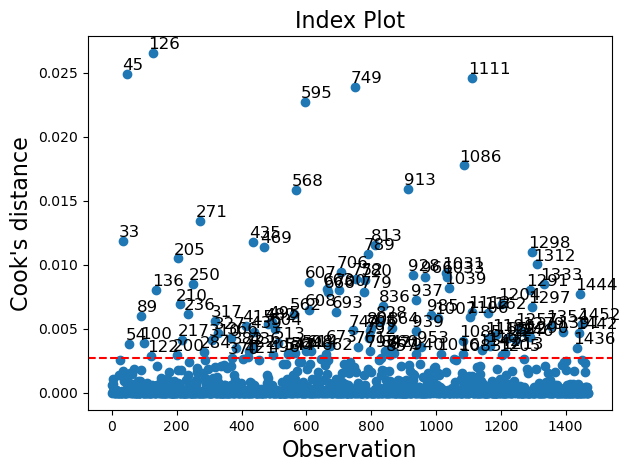

In [122]:
# Set Cook's distance threshold
cook_threshold = 4 / len(df)
print(f"Threshold for Cook Distance = {cook_threshold}")

# Plot influence measures (Cook's distance)
fig = infl.plot_index(y_var="cooks", threshold=cook_threshold)
plt.axhline(y = cook_threshold, ls="--", color='red')
fig.tight_layout(pad=1)

In [151]:
# Find number of observations that exceed Cook's distance threshold
outliers = diagnosis_df[diagnosis_df['cooks_d'] > cook_threshold]
prop_outliers = round(100*(len(outliers) / len(df)),1)
print(f'Proportion of data points that are highly influential = {prop_outliers}%')

# Display top 5 most influential outliers
outliers.sort_values("cooks_d", ascending=False).head()


Proportion of data points that are highly influential = 7.7%


,cooks_d,std_resid
126,0.026532,4.888724
45,0.024936,6.085198
1111,0.024557,11.446675
749,0.023882,8.480964
595,0.022701,2.948979


In [138]:
# Find number of observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) & 
                       (diagnosis_df['std_resid'] > 3)]
prop_extreme = round(100*(len(extreme) / len(df)),1)

# Display top 5 most influential outliers (std dev > 3)
extreme.sort_values("cooks_d", ascending=False).head()

,cooks_d,std_resid
126,0.026532,4.888724
45,0.024936,6.085198
1111,0.024557,11.446675
749,0.023882,8.480964
568,0.015874,4.345613


In [137]:
# Deep dive into index 126 (extreme outlier)
df.iloc[126]

Age                                     58
Attrition                                1
DailyRate                              147
DistanceFromHome                        23
Education                                4
EnvironmentSatisfaction                  4
Gender                                   0
HourlyRate                              94
JobInvolvement                           3
JobLevel                                 3
JobSatisfaction                          4
MonthlyIncome                        10312
MonthlyRate                           3465
NumCompaniesWorked                       1
OverTime                                 0
PercentSalaryHike                       12
PerformanceRating                        3
RelationshipSatisfaction                 4
StockOptionLevel                         1
TotalWorkingYears                       40
TrainingTimesLastYear                    3
WorkLifeBalance                          2
YearsAtCompany                          40
YearsInCurr

In [152]:
# drop outliers
indeces = (outliers.index)
df.drop(indeces, axis=0, inplace=True)


## ML Models

### Baseline ML Model - Logistic Regression

In [126]:
# Defines the modelling function incl. k-fold cross-validation
pass

### Other ML Models

#### Decision Tree

In [162]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

# Decision Tree incl. k-fold cross-validation to compare models and detect overfitting

# clf = DecisionTreeClassifier(criterion='entropy', max_depth=3)
clf = RandomForestClassifier(criterion='gini', max_depth=30, n_estimators=200)

# Train the model Classifer
clf = clf.fit(X_train,y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

# print model accuracy to terminal
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

def plot_tree(clf, features):
    
    # Setting dpi = 300 to make image clearer than default
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30,30), dpi=300)

    tree.plot_tree(clf,
           feature_names=features,
           class_names=True,
           filled=True,
           fontsize=15);

    fig.savefig('tree.png')
# plot_tree(clf, X_train.columns.tolist())


# Naive Bayes incl. k-fold cross-validation 
pass

Accuracy: 0.8995098039215687
[[366   0]
 [ 41   1]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       366
           1       1.00      0.02      0.05        42

    accuracy                           0.90       408
   macro avg       0.95      0.51      0.50       408
weighted avg       0.91      0.90      0.85       408



### Hypertuning ML Model with highest accuracy

In [128]:
# loop through a few parameters for each model and to find highest accuracy
pass


### Model Evaluation ROC Curve

In [129]:
# consolidate every model in ROC to compare the metric most important for our case